In [4]:
!git clone https://github.com/januar-png/earlystop.git

Cloning into 'earlystop'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 71 (delta 36), reused 17 (delta 7), pack-reused 0
Receiving objects: 100% (71/71), 8.01 MiB | 13.36 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [2]:
pip install jcopdl

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-2.2.2-py2.py3-none-any.whl size=29828 sha256=2cc46852244d8b461cc283172f53d88645d6075ab547af4f08d9aea083c5eefd
  Stored in directory: /root/.cache/pip/wheels/4e/3f/12/1c6bedd1b24a8d5fbd4f121312bc8bcdb816e2500fe7c79f8b
Successfully built jcopdl
Note: you may need to restart the kernel to use updated packages.


In [3]:
from jcopdl.layers import conv_block, linear_block

In [5]:
from earlystop import Earlystop

In [6]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [56]:
batch_size = 32
img_size = 224

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.RandomRotation(7),
    transforms.RandomResizedCrop(size=(img_size), scale=(0.7, 1)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/kaggle/input/padi-dataset/train', transform = train_transform)
trainloader = DataLoader(train_set, batch_size, shuffle = True)

val_set = datasets.ImageFolder('/kaggle/input/padi-dataset/val', transform = val_transform)
valloader = DataLoader(val_set, batch_size, shuffle = False)

In [57]:
feature, label = next(iter(valloader))
print(feature.shape)

torch.Size([32, 3, 224, 224])


In [96]:
def ConvBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [122]:
class CNNpenyakitPadi(nn.Module):
    def __init__(self, output_size):
        super(CNNpenyakitPadi, self).__init__()
        self.feature = nn.Sequential(
            
            ConvBlock(3, 8),
            nn.MaxPool2d(2,2),
            
            ConvBlock(8, 16),
            nn.MaxPool2d(2,2),
                         
            ConvBlock(16, 32),
            nn.MaxPool2d(2,2),
                         
            ConvBlock(32, 64),
            nn.MaxPool2d(2,2),
            
            
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(64*14*14, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [123]:
from tqdm import tqdm

In [124]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [125]:
def fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, early_stop, epochs):
    for epoch in range(epochs):
        train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

        early_stop.log(train_cost, test_cost, train_score, test_score)

        if early_stop.early_stopping(model, monitor="test_cost") or epoch >= epochs - 1:
            early_stop.plot_cost()
            early_stop.plot_score()
            break

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
early_stop = Earlystop(model, outdir="model", early_stop_patience=2)
epoch = 50

Test: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch 1: train_loss=1.3561, val_loss=1.3786, train_score=0.3775, val_score=0.3000


Test: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch 2: train_loss=1.2949, val_loss=1.3060, train_score=0.4675, val_score=0.4700


Test: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 3: train_loss=1.2400, val_loss=1.2625, train_score=0.5442, val_score=0.4975


Test: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 4: train_loss=1.2010, val_loss=1.1983, train_score=0.5892, val_score=0.6400


Test: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch 5: train_loss=1.1713, val_loss=1.1750, train_score=0.6092, val_score=0.6525


Test: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch 6: train_loss=1.1450, val_loss=1.1376, train_score=0.6308, val_score=0.6350


Test: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


Epoch 7: train_loss=1.1247, val_loss=1.1260, train_score=0.6383, val_score=0.6800


Test: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


Epoch 8: train_loss=1.1104, val_loss=1.1168, train_score=0.6608, val_score=0.7000


Test: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch 9: train_loss=1.1030, val_loss=1.0984, train_score=0.6608, val_score=0.7125


Test: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 10: train_loss=1.1073, val_loss=1.0845, train_score=0.6417, val_score=0.7150


Test: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 11: train_loss=1.0884, val_loss=1.0871, train_score=0.6775, val_score=0.7075
EarlyStop patience =  1. Best test_cost: 1.0845


Test: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 12: train_loss=1.0780, val_loss=1.0707, train_score=0.6758, val_score=0.7100


Test: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch 13: train_loss=1.0770, val_loss=1.0791, train_score=0.6833, val_score=0.7000
EarlyStop patience =  1. Best test_cost: 1.0707


Test: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch 14: train_loss=1.0636, val_loss=1.0575, train_score=0.6875, val_score=0.7275


Test: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 15: train_loss=1.0565, val_loss=1.0576, train_score=0.7042, val_score=0.7350
EarlyStop patience =  1. Best test_cost: 1.0575


Test: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


Epoch 16: train_loss=1.0522, val_loss=1.0529, train_score=0.7092, val_score=0.7250


Test: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


Epoch 17: train_loss=1.0520, val_loss=1.0645, train_score=0.6992, val_score=0.7200
EarlyStop patience =  1. Best test_cost: 1.0529


Test: 100%|██████████| 13/13 [00:22<00:00,  1.69s/it]


Epoch 18: train_loss=1.0475, val_loss=1.0487, train_score=0.6967, val_score=0.7100


Test: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


Epoch 19: train_loss=1.0357, val_loss=1.0496, train_score=0.7200, val_score=0.7275
EarlyStop patience =  1. Best test_cost: 1.0487


Test: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 20: train_loss=1.0359, val_loss=1.0391, train_score=0.7158, val_score=0.7225


Test: 100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch 21: train_loss=1.0279, val_loss=1.0444, train_score=0.7383, val_score=0.7350
EarlyStop patience =  1. Best test_cost: 1.0391


Test: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 22: train_loss=1.0262, val_loss=1.0382, train_score=0.7250, val_score=0.7400


Test: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 23: train_loss=1.0271, val_loss=1.0439, train_score=0.7217, val_score=0.7200
EarlyStop patience =  1. Best test_cost: 1.0382


Test: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 24: train_loss=1.0146, val_loss=1.0382, train_score=0.7533, val_score=0.7350
EarlyStop patience =  2. Best test_cost: 1.0382
Training early stopped. tidak ada peningkatan pada 2 epoch terakhir atau mencapai target score.
Early Stopping pada epoch: 23 | Best test_cost: 1.0382


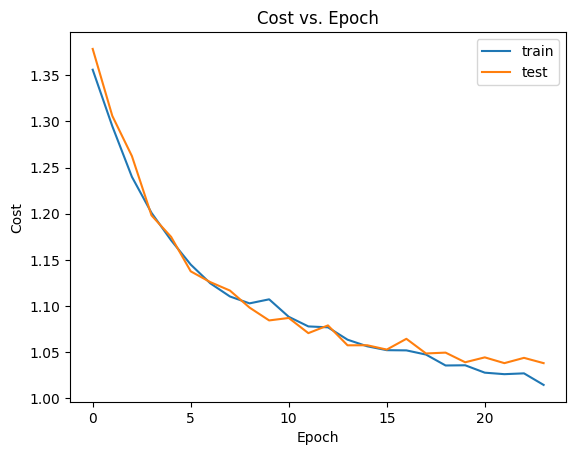

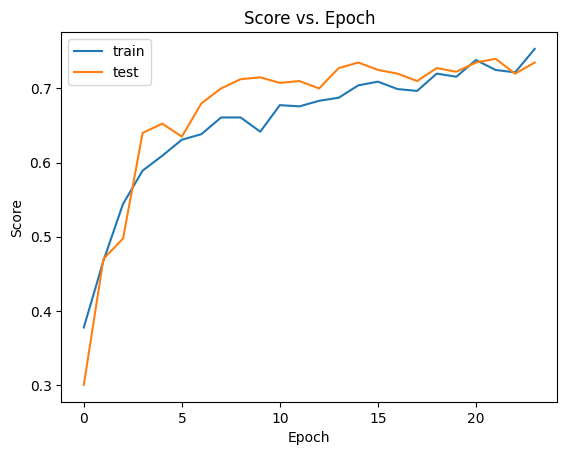

In [127]:
fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, early_stop, epoch)

In [128]:
!pip install torchsummary

In [129]:
test_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])
test_set = datasets.ImageFolder('/kaggle/input/padi-dataset/test', transform=test_transform)
testloader = DataLoader(test_set, shuffle=False)

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [131]:
def evaluate_model(model, testloader, criterion, device):
    model.load_state_dict(torch.load('/kaggle/working/model/best_model.pth'))
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    average_loss = total_loss / len(testloader)
    accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)
    
    class_counts_labels = np.bincount(all_labels)
    class_counts_predictions = np.bincount(all_predictions)

    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_set.classes, yticklabels=test_set.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 1.0778, Test Accuracy: 0.6750
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.68      0.55        50
           1       0.24      0.08      0.12        50
           2       0.83      0.96      0.89        50
           3       0.94      0.98      0.96        50

    accuracy                           0.68       200
   macro avg       0.62      0.68      0.63       200
weighted avg       0.62      0.68      0.63       200

Confusion Matrix:


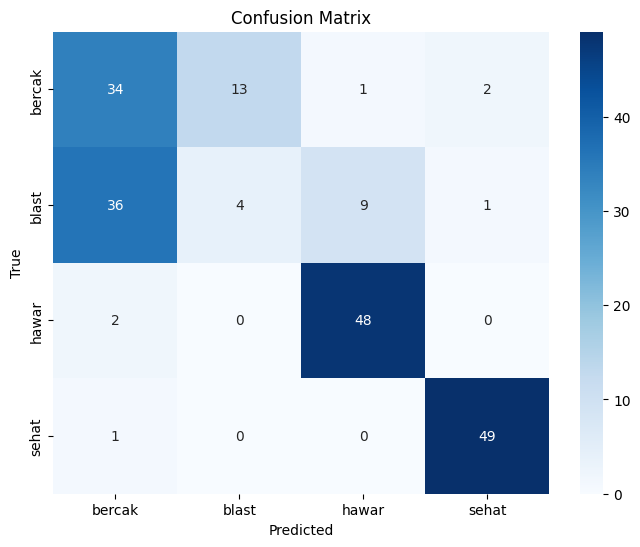

In [132]:
evaluate_model(model, testloader, criterion, device)

In [133]:
from torchsummary import summary

model = CNNpenyakitPadi(output_size = 6).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,168
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,640
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,496
      BatchNorm2d-14           [-1, 64,

In [134]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


activation1 = {}
jumlah = 100

def get_activation(name):
    def hook(module, input, output):
        activation1[name] = output.detach()
    return hook

model.feature[0][0].register_forward_hook(get_activation('conv'))
model.feature[2][0].register_forward_hook(get_activation('conv2'))
model.feature[4][0].register_forward_hook(get_activation('conv4'))

model.feature[0][2].register_forward_hook(get_activation('relu'))
model.feature[2][2].register_forward_hook(get_activation('relu3'))
model.feature[4][2].register_forward_hook(get_activation('relu5'))


img = Image.open('/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_spot (320).jpg')
rgb_image = img.convert('RGB')

transform = transforms.Compose([
    transforms.Resize(size=(224)),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.cuda()

output = model(img_tensor)

/tmp/ipykernel_47/3142080358.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


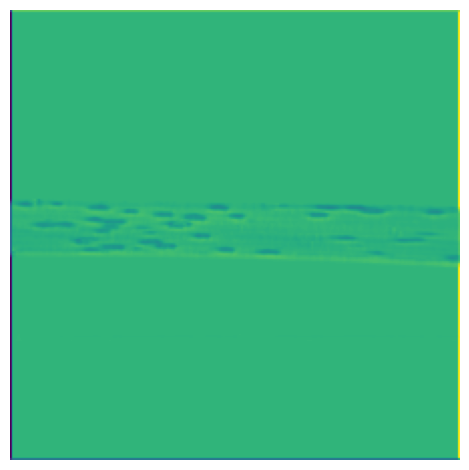

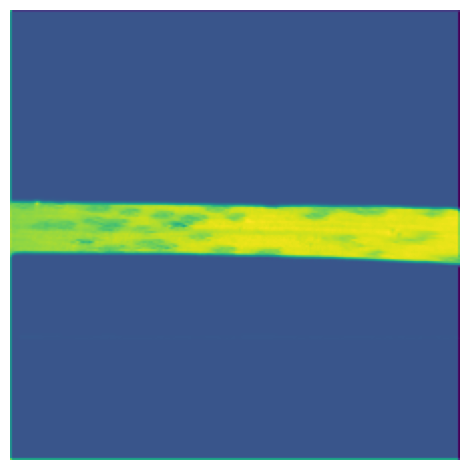

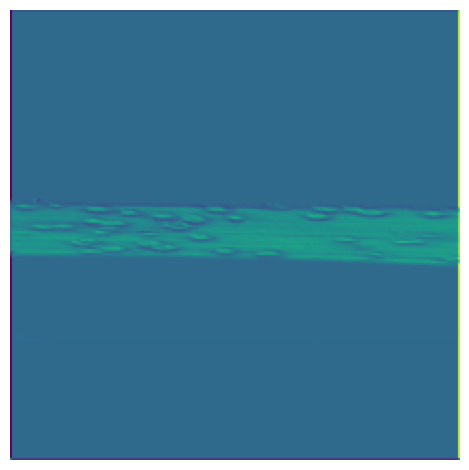

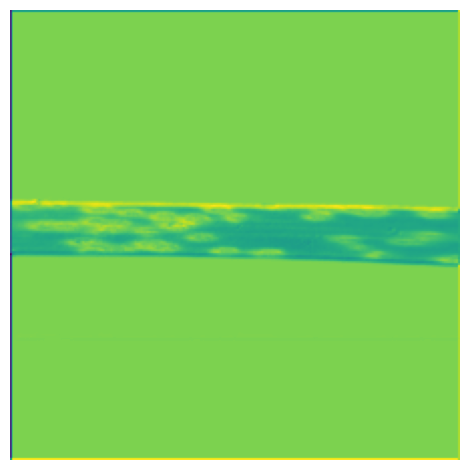

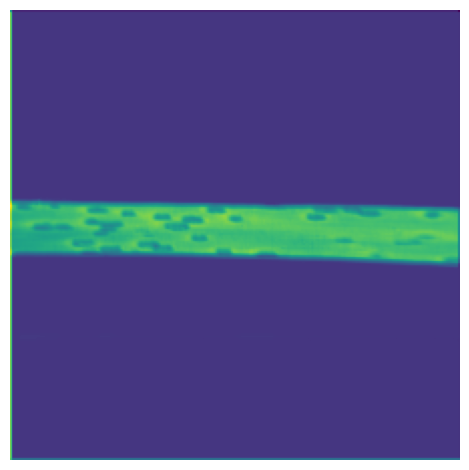

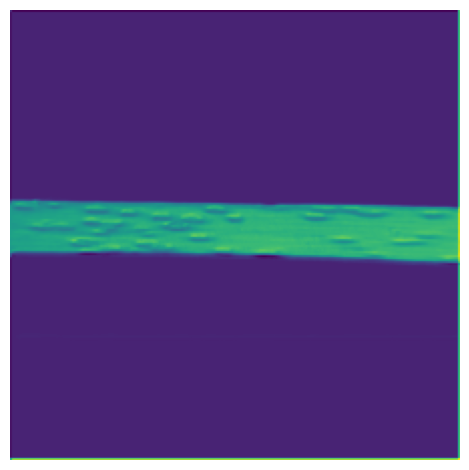

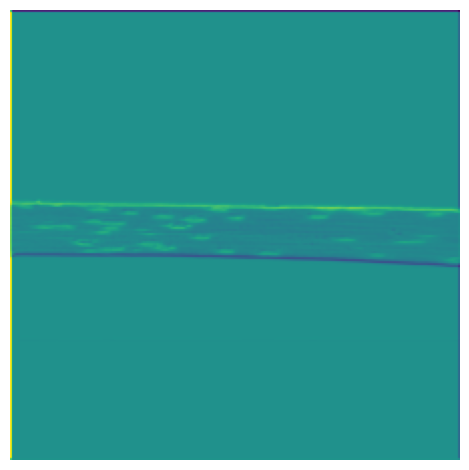

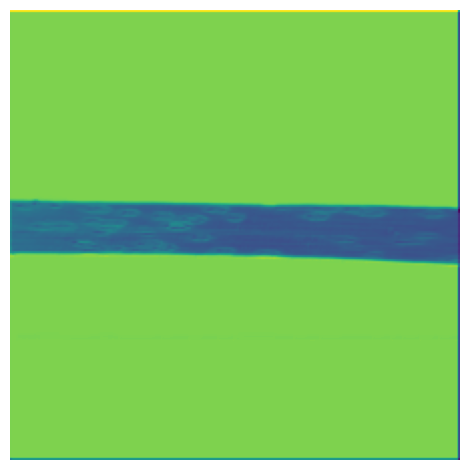

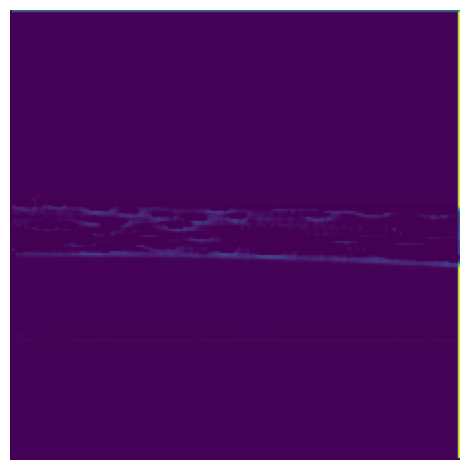

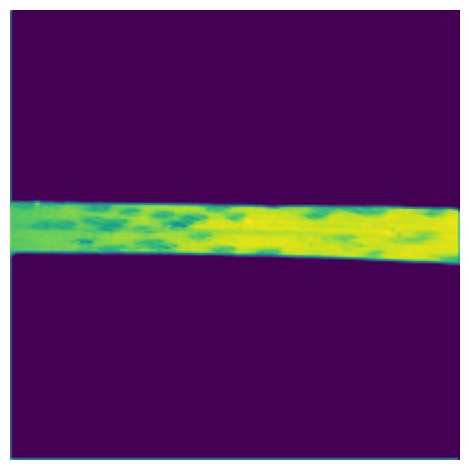

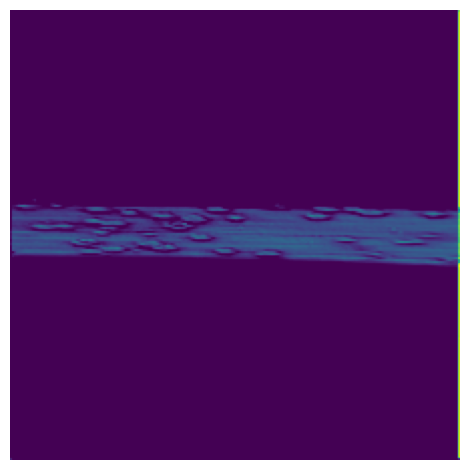

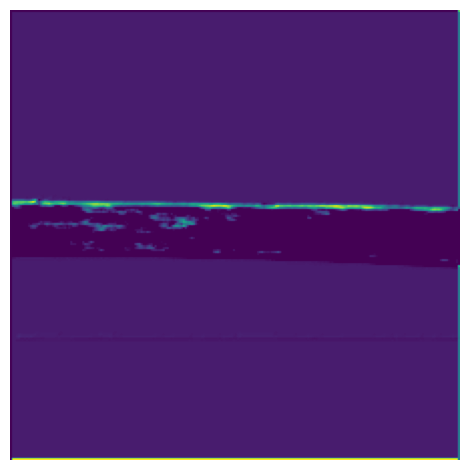

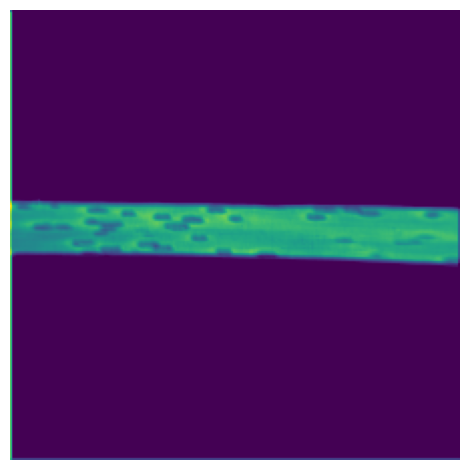

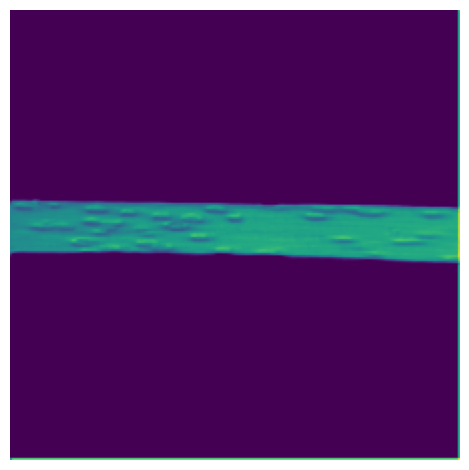

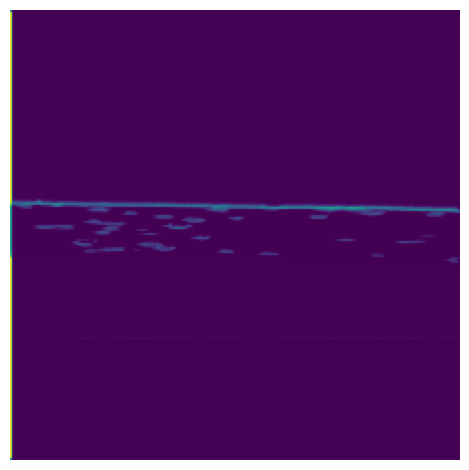

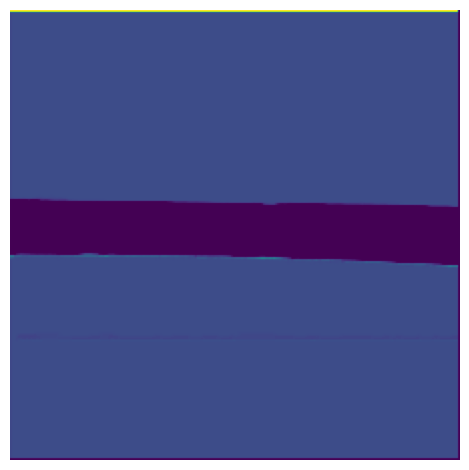

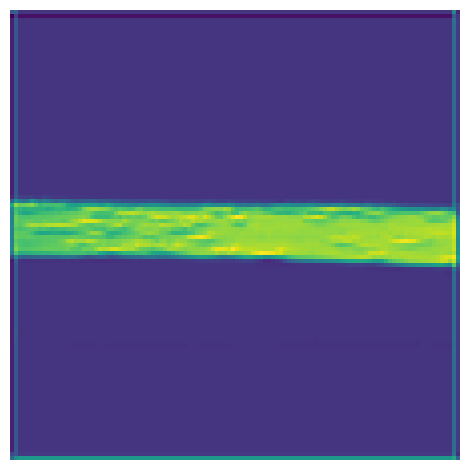

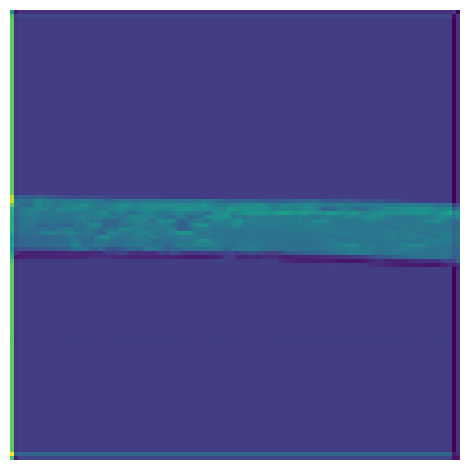

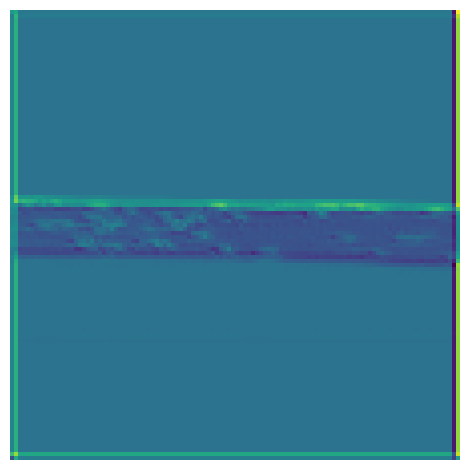

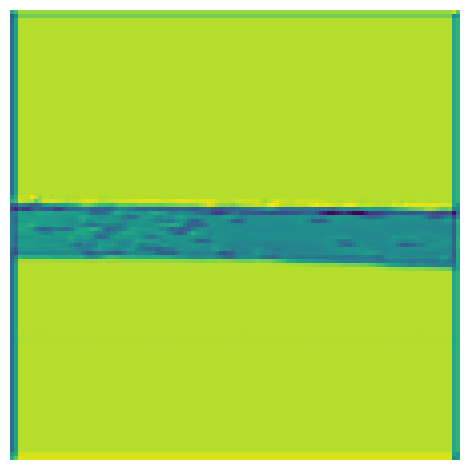

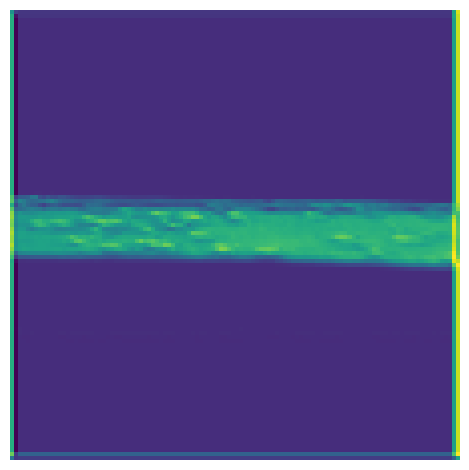

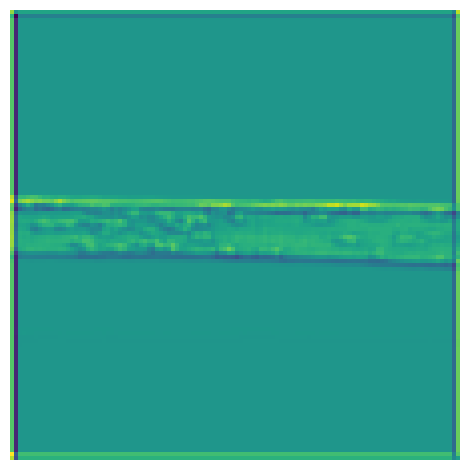

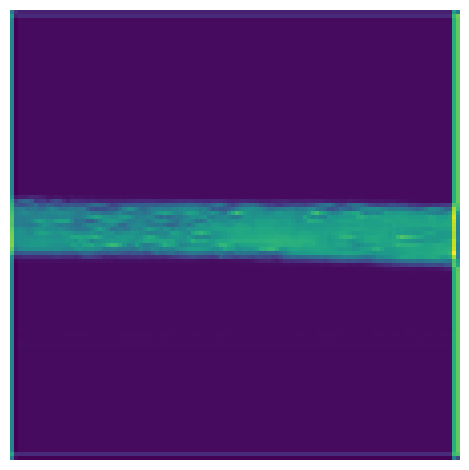

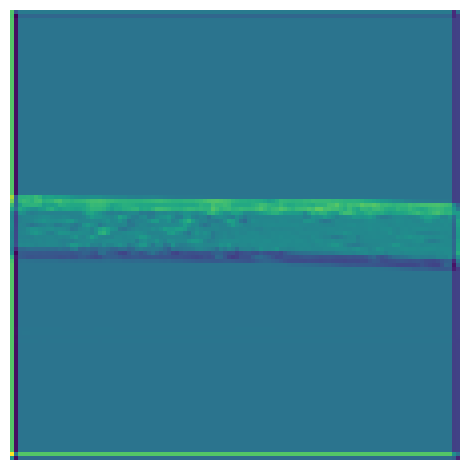

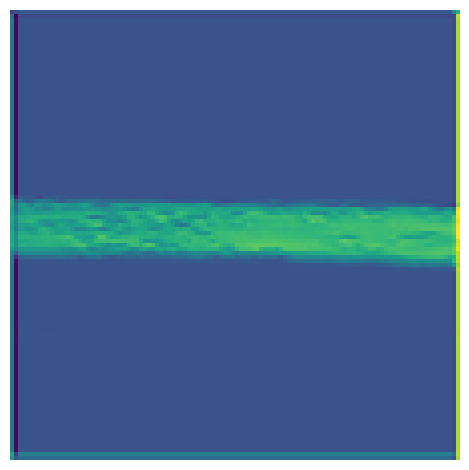

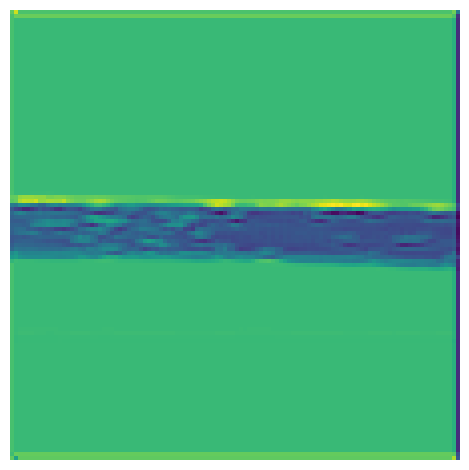

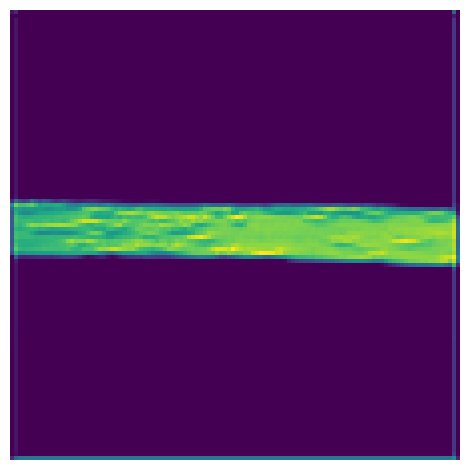

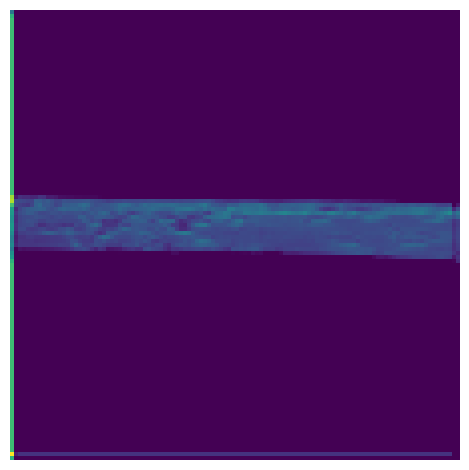

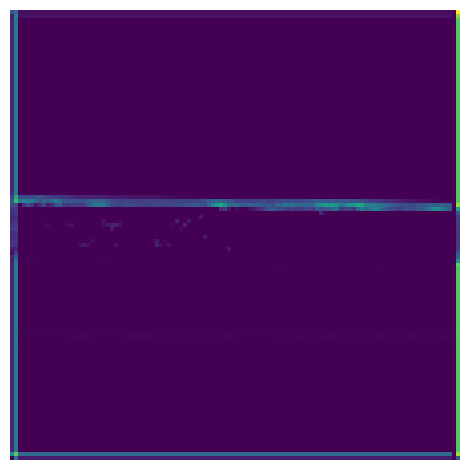

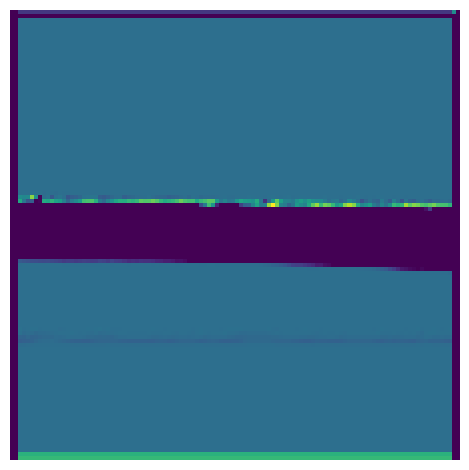

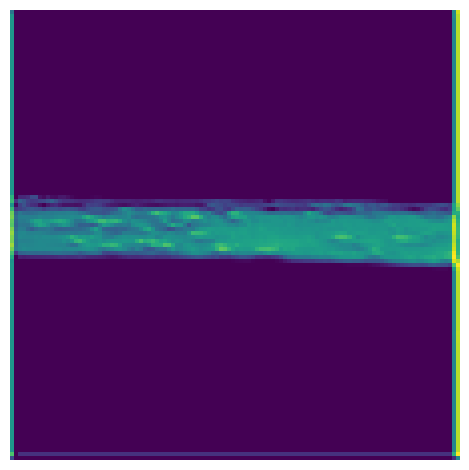

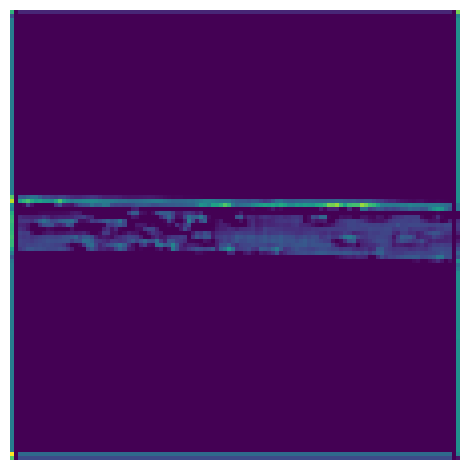

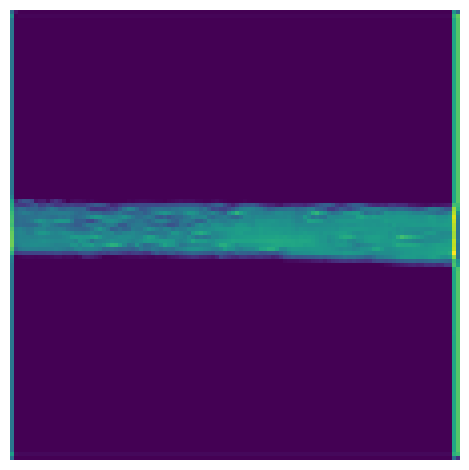

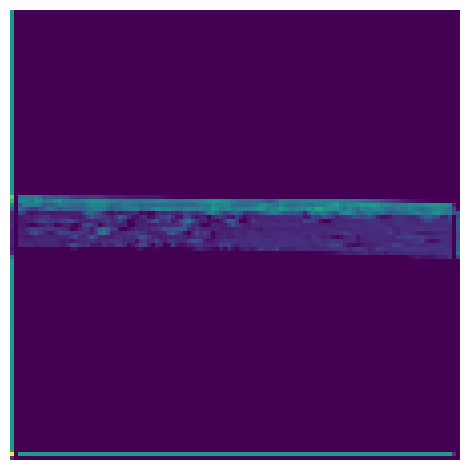

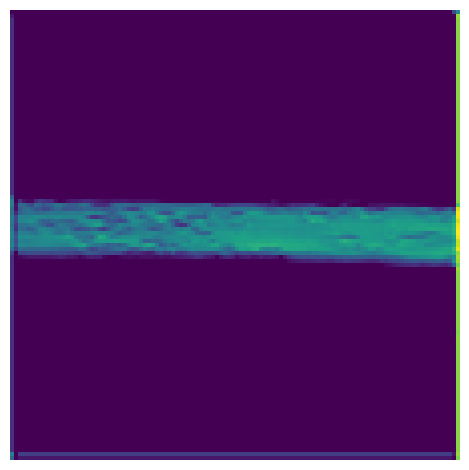

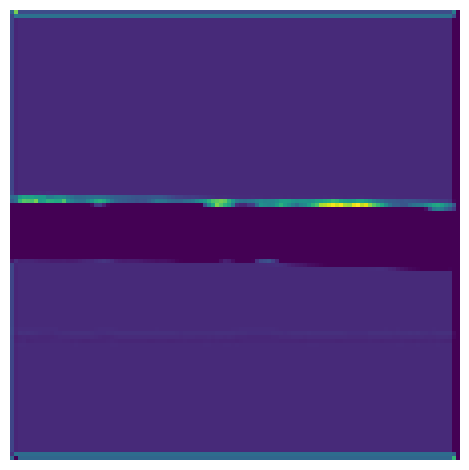

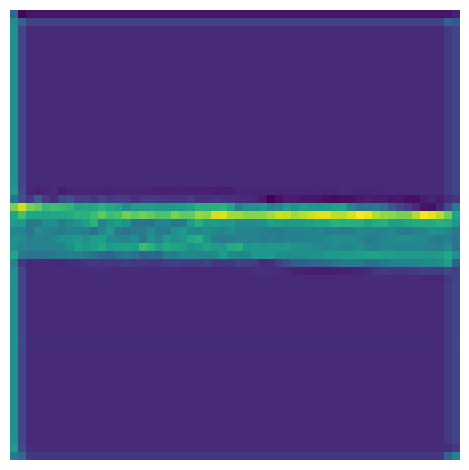

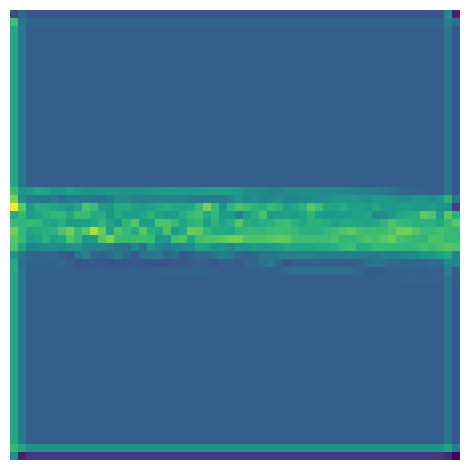

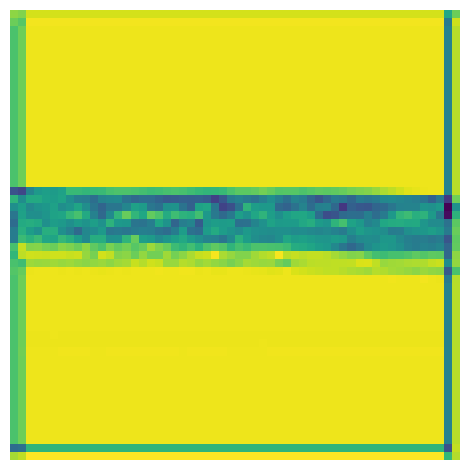

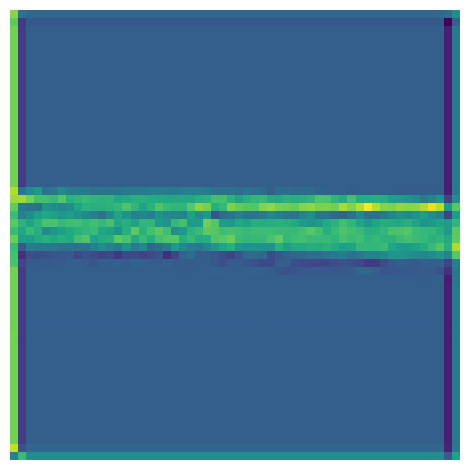

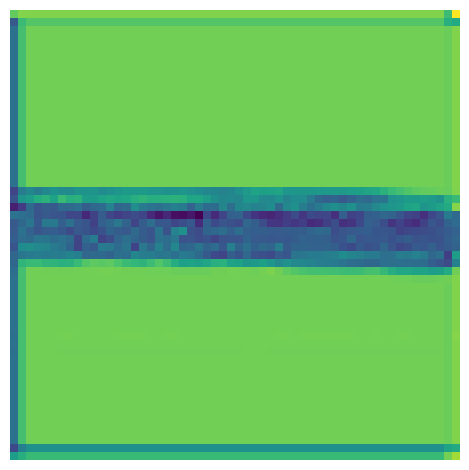

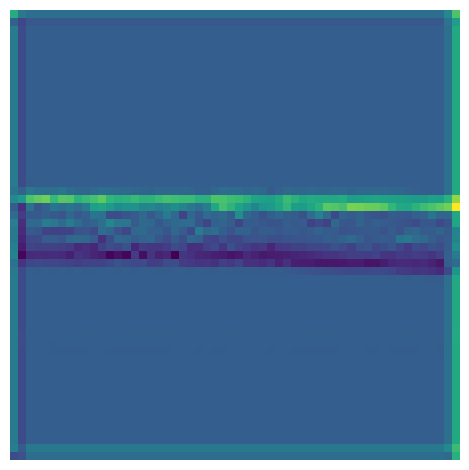

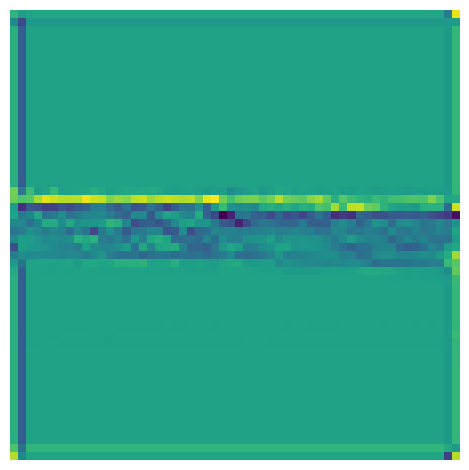

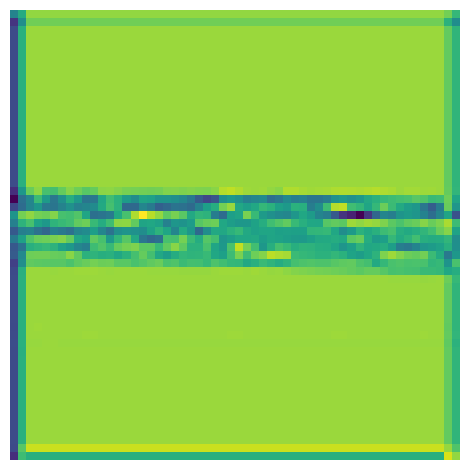

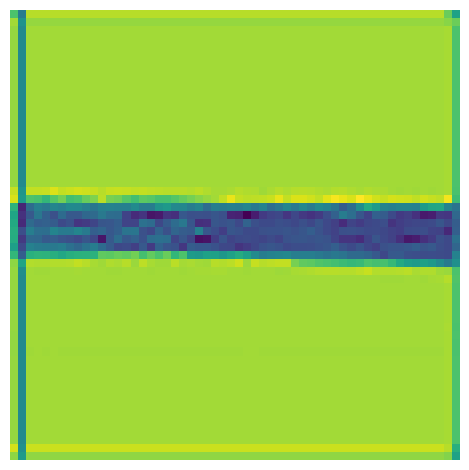

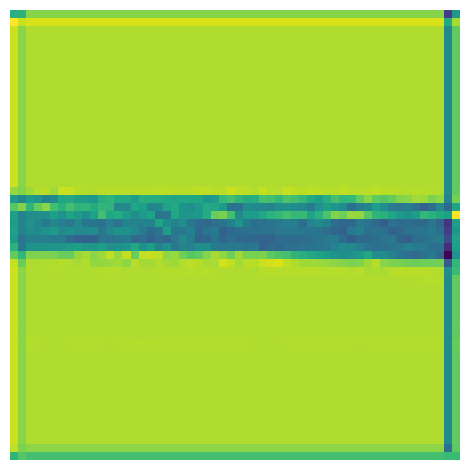

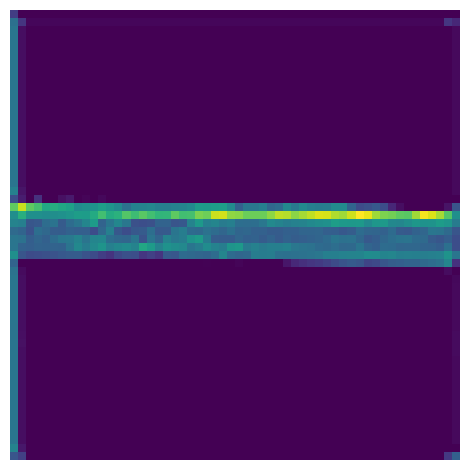

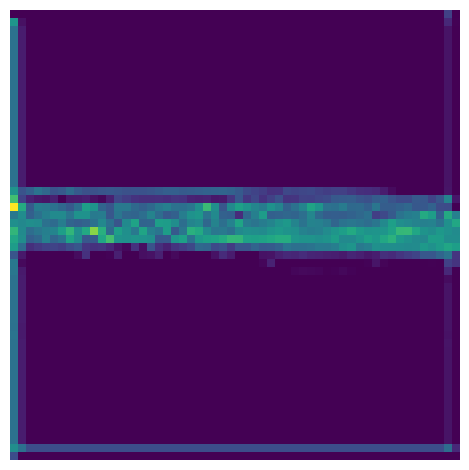

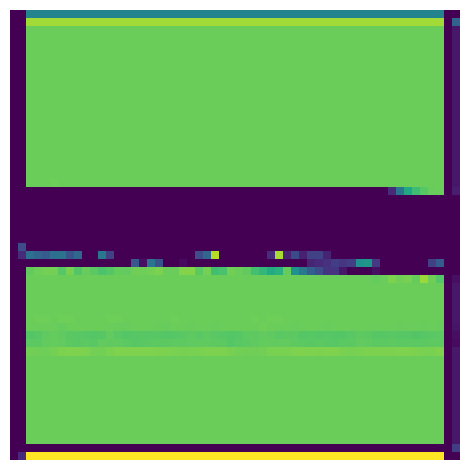

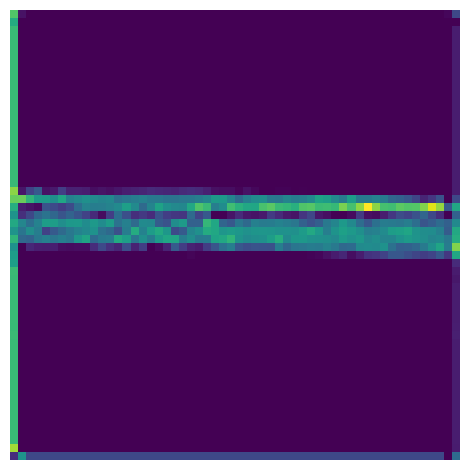

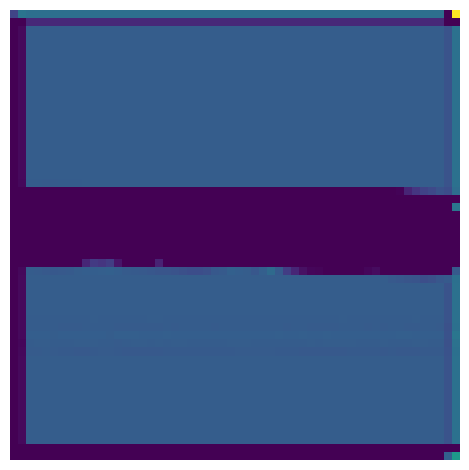

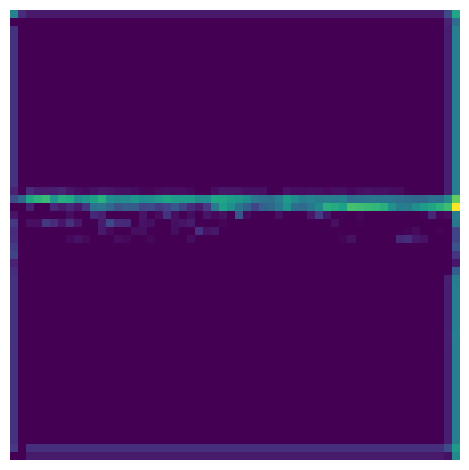

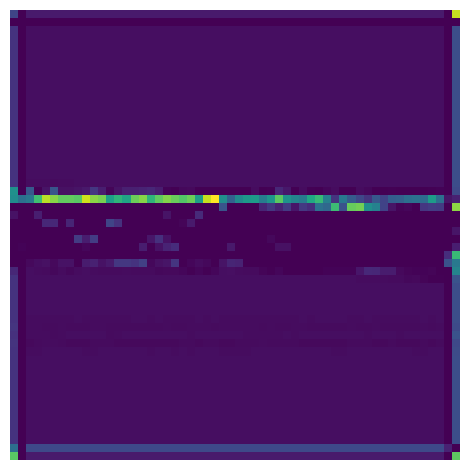

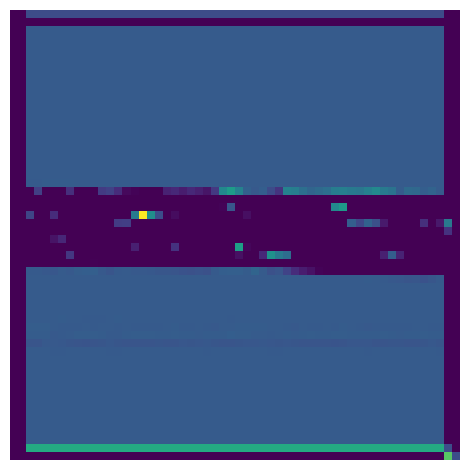

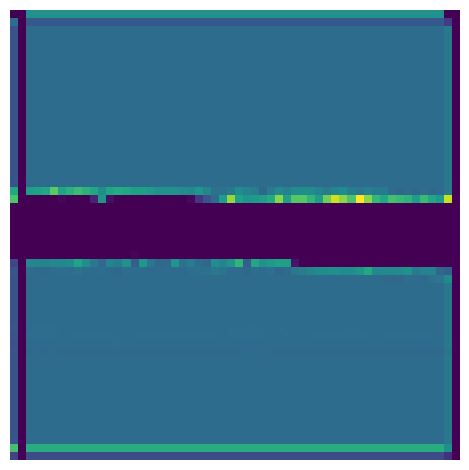

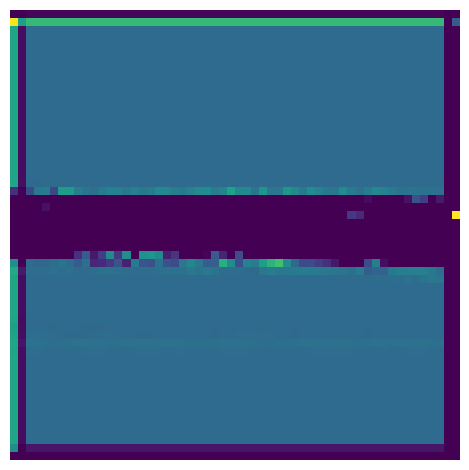

In [135]:
for name in activation1:
    folder_path = os.path.join('custom_11', name)
    file = name

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if file in activation1:
        num_images = min(max(3, activation1[file].shape[1]), 10)
        for i in range(num_images):
            fig, ax = plt.subplots(1, 1)
            ax.imshow(activation1[file][0, i].cpu().numpy())
            ax.axis('off')
            plt.tight_layout()

            fig.savefig(f'{folder_path}/{file}-{i}.png', dpi=300, transparent=True)


tensor([[[[1.0000, 0.9725, 0.7686, 0.9137, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7373, 0.8941, 1.0000, 1.0000],
          [1.0000, 0.9647, 0.7373, 0.8784, 1.0000, 1.0000],
          [1.0000, 0.9529, 0.7059, 0.8745, 1.0000, 1.0000],
          [1.0000, 0.9451, 0.6941, 0.8392, 0.9922, 1.0000],
          [1.0000, 0.9490, 0.6824, 0.7882, 0.9882, 1.0000]],

         [[1.0000, 0.9647, 0.7098, 0.8902, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7725, 0.8980, 1.0000, 1.0000],
          [1.0000, 0.9608, 0.7529, 0.8706, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.6902, 0.8627, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.7059, 0.8078, 0.9922, 1.0000],
          [1.0000, 0.9451, 0.6588, 0.7843, 0.9843, 1.0000]],

         [[1.0000, 0.9333, 0.4471, 0.7333, 1.0000, 1.0000],
          [1.0000, 0.9294, 0.4235, 0.6902, 1.0000, 1.0000],
          [1.0000, 0.9255, 0.4118, 0.6431, 0.9922, 1.0000],
          [1.0000, 0.9216, 0.3882, 0.6039, 0.9882, 1.0000],
          [1.0000, 0.9176, 0.3608, 0

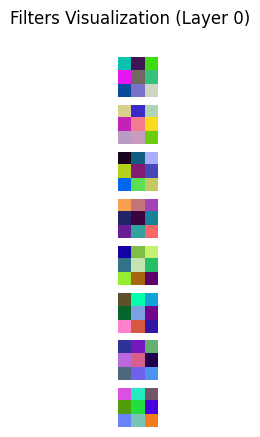

bias :tensor([-0.1221, -0.1701, -0.1228, -0.1153,  0.1764, -0.1037, -0.1326,  0.1708])


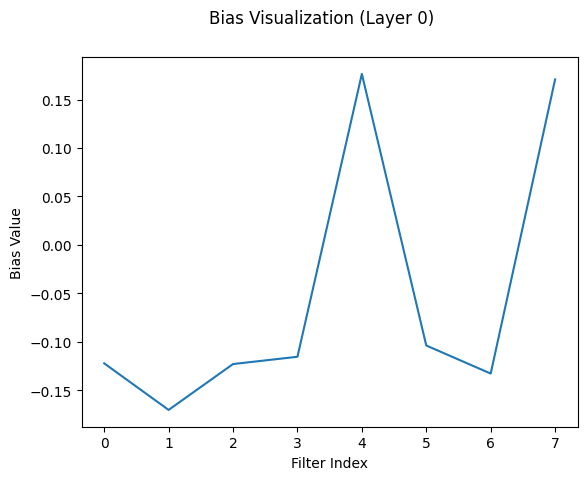

fitur :tensor([[[[ 0.1918,  0.0467,  0.0851,  0.1062,  0.1397, -0.1671],
          [-0.2350, -0.3033, -0.2312, -0.3433, -0.3264, -0.4854],
          [-0.2377, -0.3034, -0.2291, -0.3214, -0.3319, -0.4863],
          [-0.2393, -0.3067, -0.2375, -0.3219, -0.3343, -0.4868],
          [-0.2384, -0.3109, -0.2395, -0.3304, -0.3413, -0.4895],
          [-0.6520, -0.3777, -0.2877, -0.5199, -0.6140, -0.3713]],

         [[ 0.3927,  0.7230,  0.5527,  0.4756,  0.6059,  0.5656],
          [ 0.5471,  1.0748,  0.9469,  0.8106,  1.0080,  0.7277],
          [ 0.5449,  1.0714,  0.9304,  0.7962,  0.9980,  0.7271],
          [ 0.5403,  1.0611,  0.9227,  0.7794,  0.9726,  0.7240],
          [ 0.5361,  1.0526,  0.9236,  0.7322,  0.9481,  0.7195],
          [ 0.3504,  0.5701,  0.5449,  0.5079,  0.6044,  0.2298]],

         [[-0.1747, -0.1813, -0.1086, -0.1470, -0.1731, -0.2460],
          [-0.0712, -0.6811, -0.4770, -0.3117, -0.4570, -0.9308],
          [-0.0741, -0.6914, -0.4845, -0.3028, -0.4517, -0.9308],

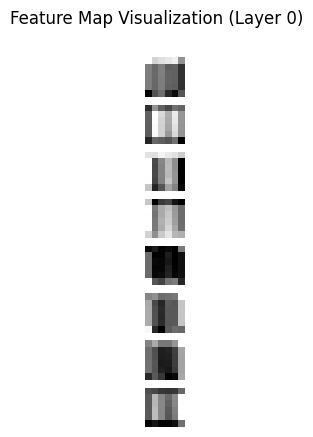

relu :tensor([[[[0.1918, 0.0467, 0.0851, 0.1062, 0.1397, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.3927, 0.7230, 0.5527, 0.4756, 0.6059, 0.5656],
          [0.5471, 1.0748, 0.9469, 0.8106, 1.0080, 0.7277],
          [0.5449, 1.0714, 0.9304, 0.7962, 0.9980, 0.7271],
          [0.5403, 1.0611, 0.9227, 0.7794, 0.9726, 0.7240],
          [0.5361, 1.0526, 0.9236, 0.7322, 0.9481, 0.7195],
          [0.3504, 0.5701, 0.5449, 0.5079, 0.6044, 0.2298]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0

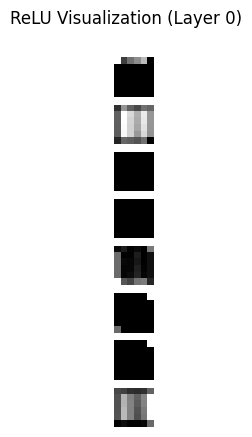

In [136]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def visualize_filters(model, layer_idx):
    layer = model.feature[layer_idx][0]
    filters = layer.weight.data
    filters = filters - filters.min()
    filters = filters / filters.max()

    fig, axs = plt.subplots(filters.size(0))
    fig.suptitle('Filters Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(filter_img.squeeze(), cmap='gray')  
        ax.axis('off')
        print(f"filer :{filter_img}")

    plt.show()
    
def visualize_bias(model, layer_idx):
    layer = model.feature[layer_idx][0]
    bias = layer.bias.data

    fig, ax = plt.subplots()
    fig.suptitle('Bias Visualization (Layer {})'.format(layer_idx))

    ax.plot(bias.cpu().numpy())
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Bias Value')
    print(f"bias :{bias}")
    plt.show()
    
    

def visualize_feature_maps(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    activations = activations.detach()

    fig, axs = plt.subplots(activations.size(1))
    fig.suptitle('Feature Map Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"fitur :{activations}")

    plt.show()

def visualize_relu(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    relu_activations = torch.relu(activations)
    relu_activations = relu_activations.detach()

    fig, axs = plt.subplots(relu_activations.size(1))
    fig.suptitle('ReLU Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(relu_activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"relu :{relu_activations}")

    plt.show()

output_size = 10  
model = CNNpenyakitPadi(output_size)

transform = transforms.Compose([
    transforms.Resize((6,6)),
    transforms.ToTensor()
])

image_path = '/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_val (50).jpg' 
input_image = Image.open(image_path)
input_image = transform(input_image).unsqueeze(0)


print(input_image)


visualize_filters(model, 0)

visualize_bias(model, 0)

visualize_feature_maps(model, 0, input_image)

visualize_relu(model, 0, input_image)